# Lab 7 - Algorithimic Fairness of Predictive Models

Today, we will discuss different notions of fairness in the predictive setting.

More specifically, we will go through a running example using the Adult dataset.

# Fairness Notions

When machine learning models are being used to make decisions, they cannot be separated from the social and ethical context in which they are applied, and those developing and deploying these models must take care to do so in a manner that accounts for both performance and fairness. 

So in the last decade Fairness has become one of the most active research areas in ML.

The most popular notions are **Individual Fairness** and **Group Fairness**.

### Individual Fairness - Meritocracy
Individual fairness is a meritocratic notion of fairness, meaning that similar individuals should be treated similarly.

### Group Fairness
In group fairness, different groups should be treated equally, ensuring fair outcomes across demographic groups.

# COMPAS Dataset and Fairness Issues
There are a lot of examples that researchers demonstrate inadvertently discriminating against several population groups.

The most know is [ProPublica's](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) research in COMPAS Dataset.

The **COMPAS** (Correctional Offender Management Profiling for Alternative Sanctions) tool was used in Florida, to predict the likelihood of defendants reoffending. The model assigns a risk score based on factors like criminal history, age, and demographic data. Judges used these scores to inform decisions about bail, sentencing, and parole.

However, investigations revealed significant **racial bias** in the model’s predictions. 
Black defendants were more likely to be assigned higher risk scores, even when they did not reoffend.
Black defendants had twice "false positive rates" from white defendants.

These disparities led to concerns about **Algorithmic Fairness**.

# A2. Sources of Bias.

Bias may be introduced into a machine learning project at any step along the way, and it is important to carefully think through each potential source and how it may affect your results.


Source of bias:
- Data
    1. Historical injustice.
    2. Sample bias - Collection Bias.
    3. Limited features and datasets
    4. Unbalanced dataset.
- Modelling
    1. Data preprocessing
    2. Model assumptions 
- Feedback loops.
    1. decisions based on biassed models lead to biassed dataset.  

# A3. Load Dataset

https://archive.ics.uci.edu/ml/datasets/adult

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

In [4]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binary target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)
    
    # Categorical dataset
    categorical_features = data.select_dtypes('category').columns
    data[categorical_features] = data.select_dtypes('category').apply(lambda x: x.cat.codes)
    return data

### load & clean dataset

In [5]:
# get and clean train dataset
TRAIN_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
train_data = train_data.dropna()
print("Train dataset shape:", train_data.shape)

# get and clean test dataset
TEST_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
test_data = test_data.dropna()
print("Test dataset shape:", test_data.shape)

Train dataset shape: (28938, 14)
Test dataset shape: (15175, 14)


In [6]:
target_column = "income_class"
sensitive_feature = "sex"
features = train_data.columns.difference([target_column])

In [7]:
train_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,6,9,13,4,0,1,4,1,2174.0,0,40,38,0
1,50,5,9,13,2,3,0,4,1,0.0,0,13,38,0
2,38,3,11,9,0,5,1,4,1,0.0,0,40,38,0
3,53,3,1,7,2,5,0,2,1,0.0,0,40,38,0
4,28,3,9,13,2,9,5,2,0,0.0,0,40,4,0


### Data analysis

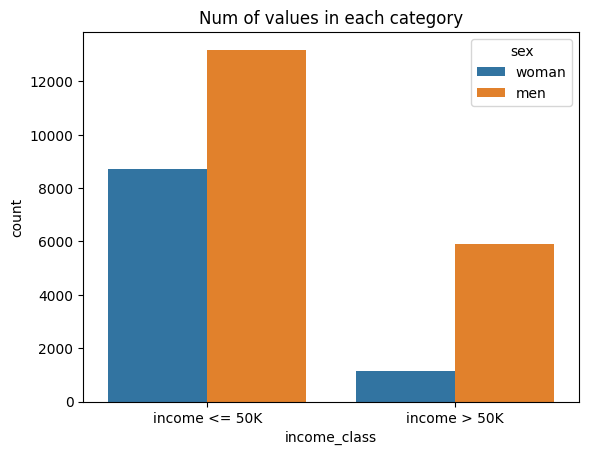

In [9]:
plt.figure()
fig = sns.countplot(data=train_data[["income_class","sex"]],
                    x="income_class",
#                     stat="proportion",
                    hue="sex")
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.legend(title='sex', labels=['woman', 'men'])
plt.title("Num of values in each category")
plt.show()
plt.close()

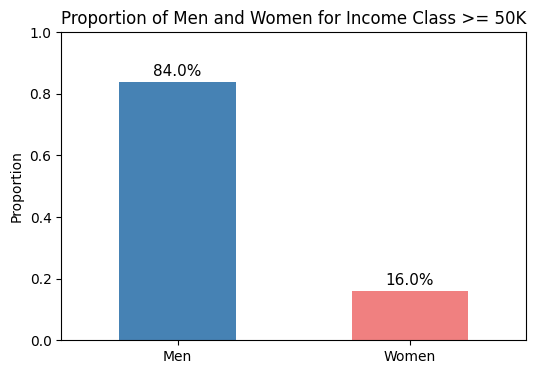

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to income_class = 1
subset = train_data[train_data["income_class"] == 1]

# Compute proportions
prop = subset["sex"].value_counts(normalize=True)

# Map numeric sex to names (only if needed)
sex_labels = {
    1: "Men",
    0: "Women",
    "Male": "Men",
    "Female": "Women"
}
prop.index = prop.index.map(lambda x: sex_labels.get(x, x))

# Choose custom colors
colors = ["steelblue", "lightcoral"]  # Men, Women

# Plot
ax = prop.plot(
    kind="bar",
    figsize=(6,4),
    color=colors
)

plt.ylabel("Proportion")
plt.title("Proportion of Men and Women for Income Class >= 50K")
plt.xticks(rotation=0)
plt.ylim(0, 1)

# Add percentages above bars
for i, v in enumerate(prop):
    ax.text(i, v + 0.02, f"{v*100:.1f}%", ha="center", fontsize=11)

plt.show()


### Data Scalling

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(train_data[features]),columns = features)

X_test = pd.DataFrame(scaler.transform(test_data[features]),columns = features) # note that here we just use the transform method!

The dataset is quite imbalance between a gender, so we expect our model to be unfair.
The source of the bias is coming from our societal bias.

# A4. Train a Model
let's train our model and analyse the results.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)

model.fit(X = X_train[features],
          y = train_data[target_column])

KNeighborsClassifier(n_neighbors=15)

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
test_data[target_column]

0        0
1        0
2        1
3        1
4        0
        ..
16276    0
16277    0
16278    0
16279    0
16280    1
Name: income_class, Length: 15175, dtype: int64

In [26]:
predictions = model.predict(X_test[features])
accuracy = accuracy_score(y_true=test_data[target_column], y_pred=predictions)

In [27]:
accuracy

0.8392751235584843

In [28]:
acc_score = accuracy_score(y_true = test_data[target_column],
                           y_pred = model.predict(X_test[features]))
print("Accuracy_score:", acc_score)

Accuracy_score: 0.8392751235584843


# A5. Analysis of model fairness


Unfortunately, there is no single definition of fairness. Many competing approaches exist to measure whether a model is statistically “fair.” It is essential to start with the social and policy goals for equity and fairness, and then map those goals to the statistical properties we seek in our models to help achieve them. Most definitions involve dividing the population into groups and comparing specific metrics across these groups.

Different definitions prioritize different fairness aspects, so the appropriate choice of fairness definition depends on the application. This typically requires a careful consideration of the project’s goals and a thorough discussion between data scientists, decision-makers, and those impacted by the model's use.

Below, we define some of the most widely recognized fairness definitions:

1. **Demographic Parity** - equal positive outcome rates across groups.
2. **Equalized Opportunities** - equal true positive rates across groups.
3. **Equalized Odds** - equal true positive and false positive rates across groups.
4. **Predictive Parity** - equal positive predictive values (precision) across groups.  
5. **Equal Accuracy** - Equal overall accuracy rates across groups.  
.  
.  

In [29]:
predictions = model.predict(X_test[features])
predictions = pd.Series(predictions,index = test_data.index)
sensitive_atribute = test_data[sensitive_feature]

In [30]:
woman_mask = sensitive_atribute == 0
predictions_woman = predictions.loc[woman_mask]
labels_woman = test_data.loc[woman_mask, target_column]

acc_score1 = accuracy_score(y_true = labels_woman,
                            y_pred = predictions_woman)
print("Accuracy_score:", acc_score1)

Accuracy_score: 0.9182279469164715


In [31]:
man_mask = sensitive_atribute == 1
predictions_man = predictions.loc[man_mask]
labels_man = test_data.loc[man_mask, target_column]

acc_score2 = accuracy_score(y_true = labels_man,
                           y_pred = predictions_man)
print("Accuracy_score:", acc_score2)

Accuracy_score: 0.7990249726395383


In [32]:
Diffrence_on_accuracy = np.abs(acc_score1 - acc_score2)
Diffrence_on_accuracy

0.11920297427693316

## F1.  Demographic Parity


Demographic Parity states that the positive prediction rates between sensitive group must be the same.

---------------
> **Definition Demographic Parity :** We say that a predictor $\hat{Y}$ satisfy **demographic parity** if the predictions $\hat{Y}$ are independent of the sensitive atribute $S$, $\hat{Y} \perp S$.
$$ P_r(\hat{Y}= 1 | S = s ) =  P_r(\hat{Y} = 1), \quad  \forall s\in S $$

in case of 2 sensitive classes, $ s \in \{0,1\}  $ we mesure the bias of model as follows:
$$DP = \; \mid P_r(\hat{Y}= 1 | S = 0 ) -  P_r(\hat{Y}= 1 | S = 1 ) \mid $$  
---------------

In [33]:
def demographic_parity_difference(predictions, sensitive_atribute):
    """
    Implementation of demographic parity difference for different groups of sensitive attribute
    1. For each group calculate the proportion of accepted rate.
    2. Find the maximum and the minim group.
    3. Calculate the difference.
    """
    # 1. For each group calculate the proportion of positive predictions.
    # group 0 
    group0_mask = sensitive_atribute == 0
    predictions_group0 = predictions[group0_mask]

    positive_rate_group0 = np.sum(predictions_group0 == 1)*1/ predictions_group0.shape[0]

    # group 1 
    group1_mask = sensitive_atribute == 1
    predictions_group1 = predictions[group1_mask]

    positive_rate_group1 = np.sum(predictions_group1 == 1)*1 / predictions_group1.shape[0]
    
    # 3. Calculate the different.
    difference = np.abs(positive_rate_group0-positive_rate_group1)
    
    return difference, [positive_rate_group0, positive_rate_group1]

In [34]:
predictions = model.predict(X_test[features])
sensitive_attribute = test_data["sex"]

In [35]:
demographic_metric, rates = demographic_parity_difference(predictions, sensitive_attribute)

In [36]:
print(f"Demographic parity difference is: {round(demographic_metric,5)}")

Demographic parity difference is: 0.1965


In [37]:
print(f"The rate of different groups are: {rates}")

The rate of different groups are: [0.07650273224043716, 0.27300766092926076]


**Potential issues?** 
1. **Laziness**: We can satisfy demographic parity in we accept random people in group S=0. We avoid lasyness because classfication is usually perfomred by optimizing an perfomance metric.
2. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F2. Equalized Opportunities

Equalized Opportunities states that each group has equal true positive rates.

---------------
> **Definition Equalized Opportunities :** We say that a predictor $\hat{Y}$ satisfy **equalized opportunities** if the predictions $\hat{Y}$ are independent of the sensitive atribute $S$, conditioned on the positive actual outcome $Y = 1$, $\hat{Y} \perp S \mid Y = 1$.
$$ P_r(\hat{Y} = 1 | S = s, Y = 1) = P_r(\hat{Y} = 1 | Y = 1), \quad \forall s \in S $$

in case of 2 sensitive classes, $ s \in \{0,1\}  $ we mesure the bias of model as follows:
$$EO = \; \mid P_r(\hat{Y} = 1 | S = 0, Y = 1) -  P_r(\hat{Y} = 1 | S = 1, Y = 1) \mid $$  
---------------

In [28]:
def equalized_opportunities_difference(predictions, actual, sensitive_attribute):
    """
    Implementation of demographic parity difference for different groups of sensitive attribute
    1. For each group calculate the proportion of positive predictions.
    2. Calculate the difference.
    """
    # 1. For each group calculate the proportion of positive predictions.
    # group 0 
    true_positive_mask = test_data[target_column]==1
    group0_mask = sensitive_attribute == 0
    predictions_group0 = predictions[np.logical_and(group0_mask, true_positive_mask)]

    true_positive_rate_group0 = np.sum(predictions_group0 == 1)*1/ predictions_group0.shape[0]

    # group 1 
    group1_mask = sensitive_attribute == 1
    predictions_group1 = predictions[np.logical_and(group1_mask, true_positive_mask)]

    true_positive_rate_group1 = np.sum(predictions_group1 == 1)*1 / predictions_group1.shape[0]
    
    # 3. Calculate the different.
    difference = np.abs(true_positive_rate_group0-true_positive_rate_group1)
    
    return difference, [true_positive_rate_group0, true_positive_rate_group1]

In [29]:
predictions = model.predict(X_test[features])
sensitive_attribute = test_data["sex"]
actual = test_data[target_column]

In [30]:
equalized_opportunities_metric, _ = equalized_opportunities_difference(predictions, actual, sensitive_attribute)

In [31]:
print(f"equalized opportunities difference is: {round(equalized_opportunities_metric,5)}")

equalized opportunities difference is: 0.14431


## F3. Equalized Odds

**Equalized Odds** , also referred to as

Equalized Odds states that the true positive rates (TPR) and false positive rates (FPR) between sensitive group must be the same.

---------------
> **Definition Equalized Odds :** A classifier $C$ We say that a predictor $\hat{Y}$ satisfy **equalized Odds** if the predictions $\hat{Y}$ are independent of the sensitive atribute $S$, conditioned on the actual outcome \( Y \), $\hat{Y} \perp S \mid Y$.
$$ P_r(\hat{Y} = 1 | S = s, Y = y) = P_r(\hat{Y} = 1 | Y = y), \quad \forall s \in S \quad \forall y \in Y$$

in case of 2 sensitive classes, $ s \in \{0,1\}  $ we want to satisfy both:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$ 
and 
$$ P_c(\hat{Y}= 1 | S = 0, Y = 0 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 0 ) $$  
---------------
we mesure the bias of model as follows:
$$EOds = \; \mid P_r(\hat{Y} = 1 | S = 0, Y = 1) -  P_r(\hat{Y} = 1 | S = 1, Y = 1) \mid + \mid P_r(\hat{Y} = 1 | S = 0, Y = 0) -  P_r(\hat{Y} = 1 | S = 1, Y = 0) \mid  $$  

In [35]:
def equalized_odds_difference(predictions, data, sensitive_atribute):
    """
    Implementation of equalized odds difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Calcaulte the difference.
    3. For each group calculate the TPR.
    4. Calcaulte the difference.
    5. sum the Calcaulte the differences
    """
    # A. For each group calculate the true positive rate.
    # group 0 
    true_positive_mask = data[target_column]==1
    group0_mask = sensitive_atribute == 0
    predictions_group0 = predictions[np.logical_and(group0_mask, true_positive_mask)]
    true_positive_rate_group0 = np.sum(predictions_group0 == 1)*1/ predictions_group0.shape[0]

    # group 1 
    group1_mask = sensitive_atribute == 1
    predictions_group1 = predictions[np.logical_and(group1_mask, true_positive_mask)]
    true_positive_rate_group1 = np.sum(predictions_group1 == 1)*1 / predictions_group1.shape[0]
    
    # Calculate the different.
    difference1 = np.abs(true_positive_rate_group0-true_positive_rate_group1)
    
    # B. For each group calculate the false positive rate.
    # group 0 
    true_negative_mask = data[target_column]==0
    group0_mask = sensitive_atribute == 0
    predictions_group0 = predictions[np.logical_and(group0_mask, true_negative_mask)]
    false_positive_rate_group0 = np.sum(predictions_group0 == 1)/ predictions_group0.shape[0]

    # group 1 
    group1_mask = sensitive_atribute == 1
    predictions_group1 = predictions[np.logical_and(group1_mask, true_negative_mask)]
    false_positive_rate_group1 = np.sum(predictions_group1 == 1) / predictions_group1.shape[0]
    
    # Calculate the different.
    difference2 = np.abs(false_positive_rate_group0-false_positive_rate_group1)
    
    # Total difference
    difference = difference1 + difference2
    return difference, ([true_positive_rate_group0,true_positive_rate_group1], [false_positive_rate_group0,false_positive_rate_group1])

In [36]:
predictions = model.predict(X_test[features])

In [38]:
equalized_odds_metrics, _ = equalized_odds_difference(predictions=predictions,
                                                      data=test_data,
                                                      sensitive_atribute=test_data["sex"])

In [39]:
print(f"equalized odds difference is: {round(equalized_odds_metrics,5)}")

equalized odds difference is: 0.24304


In [40]:
results = pd.DataFrame([acc_score,
                        demographic_metric,
                        equalized_opportunities_metric,
                        equalized_odds_metrics], 
                       index = ["accuracy",
                                "demographic_metric",
                                "equalized_opportunities",
                                "equalized_odds"],
                       columns = ["model"])

For your project you have explained why you choose the specific fairness criteria.

In [41]:
def compute_metric(y_pred, data, sensitive_feature):
    # get all metrics
    acc_score = accuracy_score(y_true=data[target_column], y_pred=y_pred)
    
    demographic_metric, _ = demographic_parity_difference(y_pred,
                                                          sensitive_feature)
    
    equalized_opportunities_metric, _ = equalized_opportunities_difference(y_pred,
                                                                           data,
                                                                          sensitive_feature)
    equalized_odds_metrics, _ = equalized_odds_difference(y_pred,
                                                          data,
                                                          sensitive_feature)
    
    return {
            "accuracy": acc_score,
            "demographic_metric": demographic_metric,
            "equalized_opportunities" : equalized_opportunities_metric,
            "equalized_odds": equalized_odds_metrics
            }

# B. Mitigate Bias

Numerous recent papers have proposed mechanisms to enhance fairness in machine learning algorithms.

In summary, there are three general methods to correct an unfair classifier:

1. **Pre-Processing**: Make changes to the data before training the model, e.g., removing correlated features.
2. **In-Processing**: Make changes to the model to correct fairness, e.g., adding additional loss terms to ensure fairness.
3. **Post-Processing**: Make changes after the model's output, e.g., adjusting classification thresholds.

For an overview of different methods and fairness criteria, we refer you to the following interesting survey: [https://arxiv.org/pdf/2001.09784.pdf](https://arxiv.org/pdf/2001.09784.pdf).

### 1. Pre-Processing

Unfair models can often result from bias in the data. Pre-processing methods aim to remove bias from the data before it is used to train models. The data is transformed, and then the algorithm is trained as it would be on the original dataset.

Pre-processing techniques work by transforming the data into a different representation to remove bias. Common approaches include re-balancing techniques, removing sensitive features and their proxy variables, or using machine learning techniques, such as representation learning, to transform the data into a fair representation.

**Pros:**
1. Can be applied to any downstream task.
2. Independent of the final classification model.

**Cons:**
1. May reduce performance (e.g., lower accuracy)

### 2. In-Processing

In-Processing techniques incorporate fairness into the optimization process of a classifier. In general, this approach introduces constraints or regularization terms in the objective function during training. Different methods have been proposed, either as general frameworks or solutions based on specific classification algorithms.

**Pros:**
1. Good performance on both accuracy and fairness measures.
2. Flexibility in balancing the trade-off between performance and fairness.
3. No need for access to sensitive features after training.

**Cons:**
1. Certain constraints may be difficult to apply.
2. Limited to specific classifiers.
3. Requires modifying the classifier to include constraints during retraining.

### 3. Post-Processing

These methods post-process the output score of a classifier to remove bias. The most common techniques use different classification thresholds for each group to satisfy fairness criteria.

**Pros:**
1. Relatively good performance, especially on fairness measures.
2. No need to modify the classifier itself.

**Cons:**
1. Often requires test-time access to the protected attribute.

# B. Pre-Processing

### B1 Unawareness
A very intuitive but **wrong solution** is to assume that ignoring the sensitive feature we can build a fair classifier.
This approach is wrong because other feature may be correlated with our sensitive features.

We will build a **Unawareness** classifier and the compare the results with our previous classifier.

In [42]:
non_sensitive_features = features.difference([sensitive_feature])

In [43]:
from sklearn.neighbors import KNeighborsClassifier
unaware_model  = KNeighborsClassifier(n_neighbors=15)

unaware_model.fit(X = X_train[non_sensitive_features],
                  y = train_data[target_column])

KNeighborsClassifier(n_neighbors=15)

In [44]:
unaware_metrics = compute_metric(y_pred = unaware_model.predict(X_test[non_sensitive_features]),
                                 data = test_data,
                                 sensitive_feature = test_data["sex"])

In [45]:
unaware_results = pd.DataFrame(unaware_metrics,
                               index = ["unaware_model"]).T

In [46]:
unaware_results

,unaware_model
accuracy,0.839209
demographic_metric,0.183257
equalized_opportunities,0.110204
equalized_odds,0.198440


## Compare the results of 2 models

In [47]:
all_results = pd.concat([results, unaware_results],axis=1)
all_results

,model,unaware_model
accuracy,0.839275,0.839209
demographic_metric,0.196505,0.183257
equalized_opportunities,0.144309,0.110204
equalized_odds,0.243042,0.198440


<AxesSubplot: >

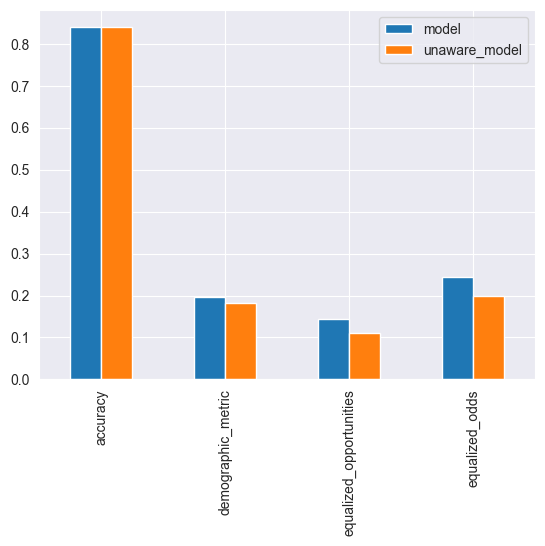

In [48]:
all_results.plot(kind="bar")

### Conclusion
Our conclusion is that we are not able to vanish unfairness by excluding sensitive features.  
The reason in that some other feature leak information about our sensitive attribute.

## B2 Remove correlated features
From the above results we expect that our sensitive feature are correlate with non-sensitive feature in our analysis.
We will try to find and exclude also those feature in order to improve our fairness properties.

In [49]:
corr = {}
for f in non_sensitive_features:
    corr[f] =np.corrcoef(test_data[sensitive_feature], test_data[f])[0,1]
corr = np.abs(pd.DataFrame(data=corr, index=["corr"]).T).sort_values(by="corr",ascending = False)

<Figure size 640x480 with 0 Axes>

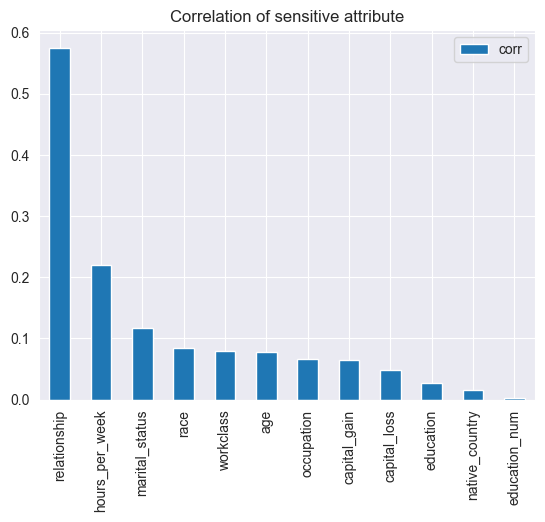

In [50]:
plt.figure()
corr.plot(kind="bar")
plt.title("Correlation of sensitive attribute")
plt.show()
plt.close()

#### Iteratively Exclude Correlated Features

Let's build a classifier while progressively removing the most correlated features in each step. This helps us see how removing correlated features affects model accuracy.

### Steps

1. **Get Feature Correlations**  
   Calculate the correlation matrix and identify the most correlated features.

2. **Iterate Over Top Correlated Features**  
   For each step \( k \):
   - Exclude the top \( k \) most correlated features.
   - Train a classifier with the remaining features.
   - Measure fairness

In [51]:
k=3
k_most_correlated = corr.iloc[0:k].index.values.tolist()

In [52]:
for i in range(len(k_most_correlated)):
    print(f"===========iteration{i+1}===========")
    training_features = list(set(non_sensitive_features).difference(set(k_most_correlated[0:i+1])))
    print("We exclude from training: ", k_most_correlated[0:i+1])
    
    # 1. train
    post_processing_model  = KNeighborsClassifier(n_neighbors=15)

    post_processing_model.fit(X = X_train[training_features],
                              y = train_data[target_column])
    

    # 2. compute matrix
    post_processing_metrics = compute_metric(y_pred= post_processing_model.predict(X_test[training_features]),
                                             data= test_data,
                                             sensitive_feature = test_data["sex"])
    
    # 3. append result
    post_processing_results = pd.DataFrame(post_processing_metrics,
                                           index = [f"pre_prossesing_{i+1}"]).T
    
    all_results = pd.concat([all_results, post_processing_results],axis=1)

===========iteration1===========
We exclude from training:  ['relationship']
===========iteration2===========
We exclude from training:  ['relationship', 'hours_per_week']
===========iteration3===========
We exclude from training:  ['relationship', 'hours_per_week', 'marital_status']


In [53]:
all_results

,model,unaware_model,pre_prossesing_1,pre_prossesing_2,pre_prossesing_3
accuracy,0.839275,0.839209,0.839934,0.840329,0.815091
demographic_metric,0.196505,0.183257,0.193080,0.178692,0.081254
equalized_opportunities,0.144309,0.110204,0.133050,0.090193,0.024357
equalized_odds,0.243042,0.198440,0.228891,0.176408,0.035784


<AxesSubplot: >

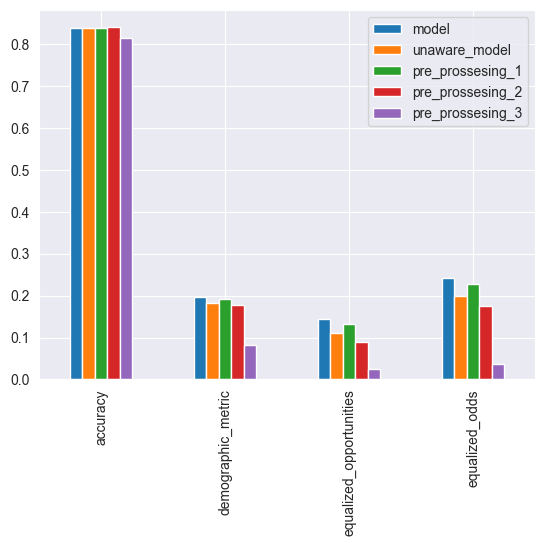

In [54]:
all_results.plot(kind="bar")

# Things to Remember

1. **ML models can be biased due to various sources,** with data-dependent biases being the most common.
2. **Selecting the appropriate fairness criterion** is essential and should align with the specific requirements of our problem.
3. **Fairness metrics can be calculated** using different rates for different groups.
4. **Removing sensitive features does not guarantee fairness** because proxy variables can still introduce bias. In many cases, removing these features does not significantly influence the algorithm.
5. **Biases can be addressed through pre-processing, in-processing, or post-processing methods.**
6. **Different methods involve trade-offs** between fairness and model performance, so choosing the right approach depends on the acceptable balance between these two factors.

For an overview of different methods and fairness critiriaa we refer you to the following survey https://arxiv.org/pdf/2001.09784.pdf.

Fairness python libraries:
https://aif360.readthedocs.io/en/stable/modules/algorithms.html
https://fairlearn.org/